In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("DynamicalSystems")
Pkg.add("Distributions")
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
using JLD2
using Test
using Random
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))
using GaussianFilters, LinearAlgebra, Distributions

  Activating environment at `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`


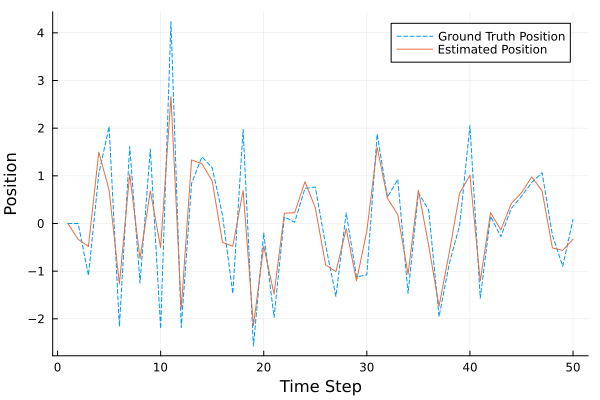

In [24]:
using ForwardDiff
using Plots

# Define the system parameters
m = 1.0   # mass in kg
c = 0.5   # damping coefficient in N*s/m
dt = 0.1  # time step in seconds

# State transition and observation matrices
A = [0 1; 0 -c/m]
B = [0; 1/m]
C = [1 0]  # observing only position

measurement_cov = [0.01]
measurement_noise = 0.00
noise = 0.1

# Define the process function (state transition model)
function process_model(x, u, dt)
    return A * x + B * u
end

# Define the measurement function
function measurement_model(x)
    return C * x
end

# Implement the Extended Kalman Filter
function extended_kalman_filter(z, Q, R, x_init, P_init, u)
    # Initialize state and covariance
    x_est = x_init
    P_est = P_init
    
    # Kalman filtering loop
    estimated_positions = zeros(length(z))  # Initialize estimated_positions vector
    for i in 1:length(z)
        # Prediction step
        x_pred = process_model(x_est, u[i], 1.0) + [noise*randn(), noise*randn()]  # Assuming time step of 1 second
        F = ForwardDiff.jacobian(x -> process_model(x, u[i], 1.0), x_est)  # Jacobian of the process model with respect to state
        P_pred = F * P_est * F' + Q
        
        # Update step
        H = ForwardDiff.jacobian(measurement_model, x_pred)  # Jacobian of the measurement model with respect to state
        K = P_pred * H' * inv(H * P_pred * H' + R)
        x_est = x_pred + K * (z[i] - measurement_model(x_pred))
        P_est = (I - K * H) * P_pred
        
        estimated_positions[i] = x_est[1]  # Assign the estimated position
    end
    
    return estimated_positions
end

# Generate noisy measurements
function simulate_damper_system(num_steps, u)
    x = [0.0, 0.0]  # Initial state (position, velocity)
    measurements = []
    for i in 1:num_steps
        y = measurement_model(x) + [measurement_noise] #[measurement_noise*randn()]  
        push!(measurements, y)
        x = process_model(x, u[i], 1.0) #+ [measurement_noise*randn(), measurement_noise*randn()]  # Add some process noise
    end
    return measurements
end

function simulate_gt(num_steps, u)
    x = [0.0, 0.0]  # Initial state (position, velocity)
    gt = []
    for i in 1:num_steps
        y = measurement_model(x)
        push!(gt, y)
        x = process_model(x, u[i], 1.0) 
    end
    return gt
end

num_steps = 50
u = randn(num_steps)  # Random control input
#simulate gt
gt = simulate_gt(num_steps, u)
measurements = simulate_damper_system(num_steps, u)


# Set initial state and covariance guess
initial_estimate = [0.0, 0.0]
initial_covariance = [1.0 0.0; 0.0 1.0]

# Set process and measurement noise covariances
process_noise_covariance = [0.01 0.0; 0.0 0.01]
measurement_noise_covariance = measurement_cov

# Run the EKF
estimated_positions = extended_kalman_filter(measurements, process_noise_covariance, measurement_noise_covariance, initial_estimate, initial_covariance, u)

# Plot the estimated positions
plot(1:num_steps, [m[1] for m in gt], label="Ground Truth Position", xlabel="Time Step", ylabel="Position", linestyle=:dash)
plot!(1:num_steps, estimated_positions, label="Estimated Position", linestyle=:solid)